In [1]:
# import require library for preprocess
import mne
import numpy as np
from mne.channels import make_standard_montage
import matplotlib.pyplot as plt
from mne.datasets import eegbci
import scipy
import pickle
import seaborn as sns
from scipy.signal import filtfilt
import pyxdf

# import require library for classification
from sklearn.svm import SVC # SVM library
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA library
from sklearn.neighbors import KNeighborsClassifier # KNN library

from sklearn.metrics import classification_report,confusion_matrix # Result representation

## 1 Read recorded data from psychopy (csv file) and OpenBCI (xdf file)

In [2]:
import pyxdf
import mne
import numpy as np
import pandas as pd

def load_data(csv_path, xdf_path):
    # Load behavioral responses
    df = pd.read_csv(csv_path)
    response = df.get("response.keys")[1:-2].to_numpy()  # Trim start/end
    
    # Load XDF EEG stream
    streams, header = pyxdf.load_xdf(xdf_path)

    # Identify EEG and Markers stream
    if streams[0]['info']['type'][0] == 'Markers':
        raw_stream = streams[1]
        event_data = streams[0]
    else:
        raw_stream = streams[0]
        event_data = streams[1]

    raw_data = raw_stream["time_series"].T
    channels = ['CH1','CH2','CH3','CH4','CH5','CH6','CH7','CH8']
    info = mne.create_info(
        ch_names=channels,
        ch_types=['eeg']*len(channels),
        sfreq=250
    )
    raw = mne.io.RawArray(raw_data, info, verbose=False)
    
    raw_filtered = raw.copy().filter(l_freq=1., h_freq=40.)
    raw_filtered = raw_filtered.copy().notch_filter(freqs=50)
    channel_mapping = {
    'CH1': 'Fz',
    'CH2': 'Cz',
    'CH3': 'Pz',
    'CH4': 'Oz',
    'CH5': 'P3',
    'CH6': 'P4',
    'CH7': 'O1',
    'CH8': 'O2'
    }
    raw_filtered.rename_channels(channel_mapping)
    raw_filtered.set_montage('standard_1020')

    return raw_filtered, response ,event_data,raw_stream


In [3]:
raw1, resp1, event_data1, raw_stream1 = load_data('psychopy_data/tai1.csv', 'data/sub-thai_ses-S001_task-Default_run-001_eeg.xdf')
raw2, resp2, event_data2, raw_stream2 = load_data('psychopy_data/tai2.csv', 'data/sub-thai_ses-S002_task-Default_run-001_eeg.xdf')
raw3, resp3, event_data3, raw_stream3 = load_data('psychopy_data/tai3.csv', 'data/sub-thai_ses-S003_task-Default_run-001_eeg.xdf')

# # --- Concatenate EEG data ---
# raw_all = mne.concatenate_raws([raw1, raw2, raw3])

# # --- Concatenate behavioral responses ---
# responses_all = np.concatenate([resp1, resp2, resp3])

# --- Continue preprocessing ---


# (Optional) set montage



# Run ICA
from mne.preprocessing import ICA
ica = ICA(n_components=8, random_state=97, max_iter='auto')
ica.fit(raw1)
ica.fit(raw2)
ica.fit(raw3)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 0.1s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,25 iterations on raw data (52550 samples)
ICA components,8
Available PCA components,8
Channel types,eeg
ICA components marked for exclusion,—


Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


c:\Users\Aitthikit\Desktop\bci_code\.venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
c:\Users\Aitthikit\Desktop\bci_code\.venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
c:\Users\Aitthikit\Desktop\bci_code\.venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


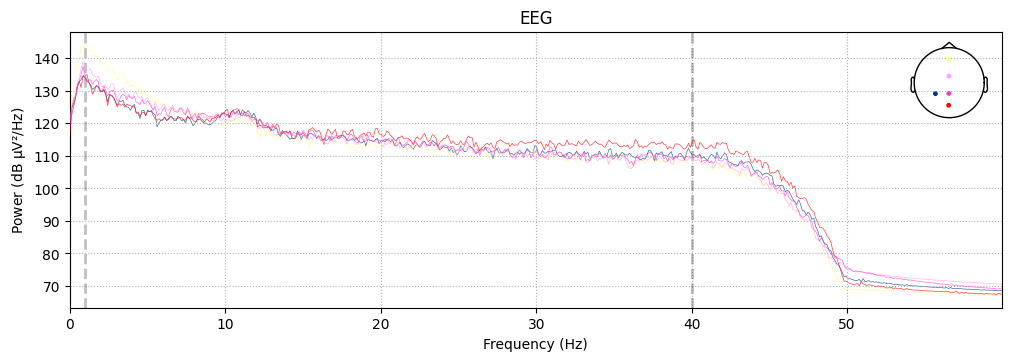

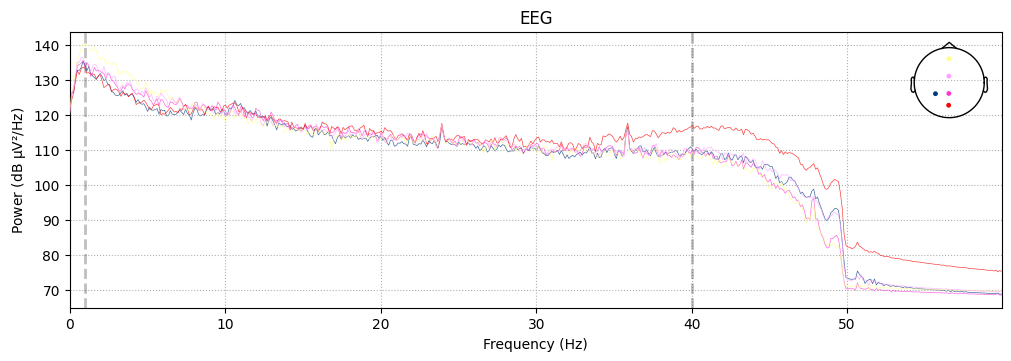

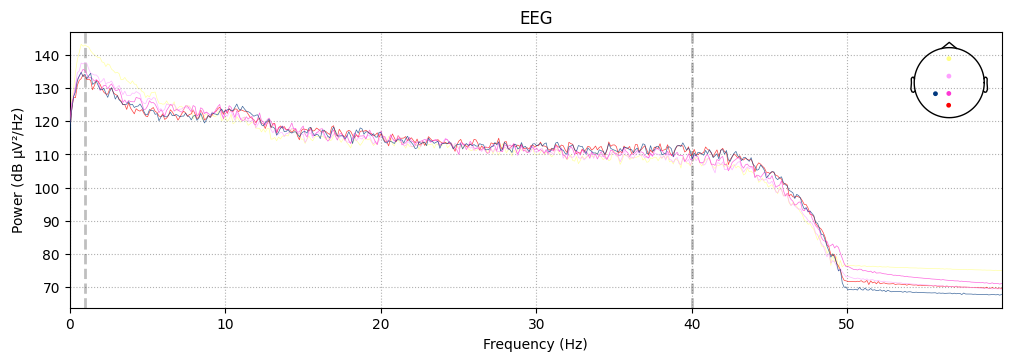

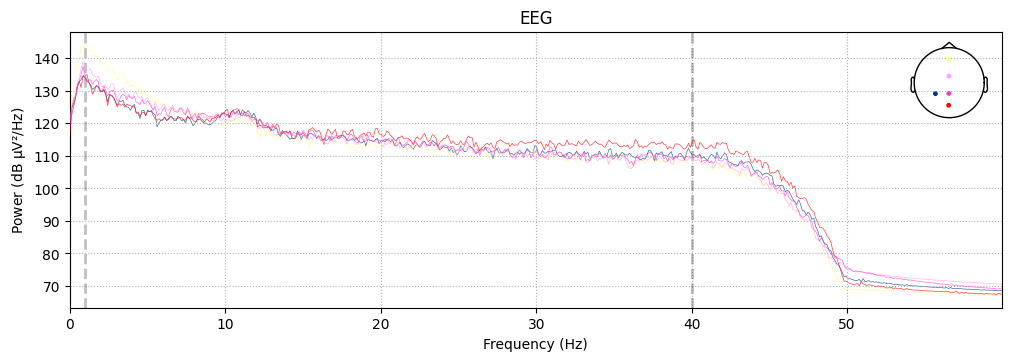

In [4]:
raw1.compute_psd(fmax=60).plot(picks=raw1.ch_names[0:5])
raw2.compute_psd(fmax=60).plot(picks=raw2.ch_names[0:5])
raw3.compute_psd(fmax=60).plot(picks=raw3.ch_names[0:5])

In [5]:
from mne_icalabel import label_components
ic_labels1 = label_components(raw1, ica, method="iclabel")
ic_labels2 = label_components(raw2, ica, method="iclabel")
ic_labels3 = label_components(raw3, ica, method="iclabel")

C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_37628\2894676983.py:2: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels1 = label_components(raw1, ica, method="iclabel")
C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_37628\2894676983.py:2: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels1 = label_components(raw1, ica, method="iclabel")
C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_37628\2894676983.py:2: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. T

In [6]:
ic_labels3

{'y_pred_proba': array([0.71431744, 0.81127846, 0.90806466, 0.9916692 , 0.9830627 ,
        0.9883471 , 0.98731494, 0.9807245 ], dtype=float32),
 'labels': ['other',
  'brain',
  'brain',
  'brain',
  'brain',
  'brain',
  'brain',
  'brain']}

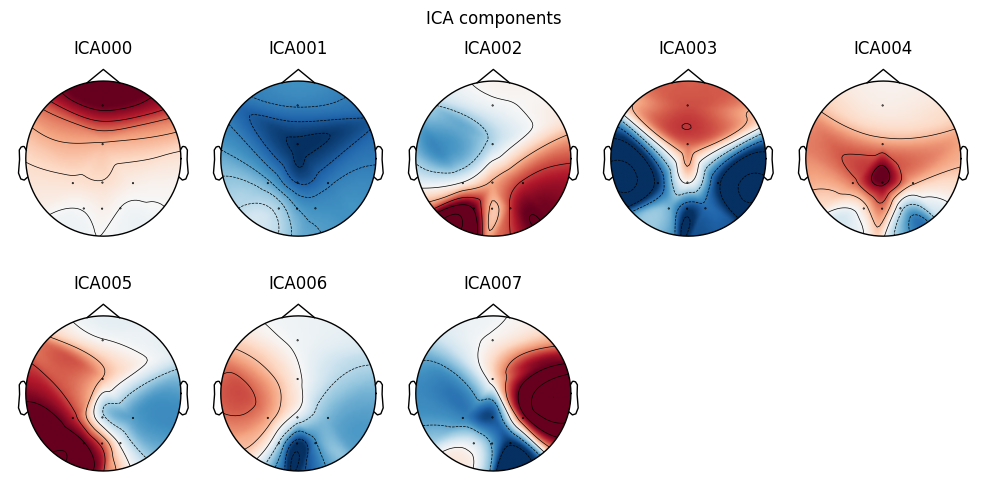

Creating RawArray with float64 data, n_channels=8, n_times=50730
    Range : 0 ... 50729 =      0.000 ...   202.916 secs
Ready.
Using matplotlib as 2D backend.


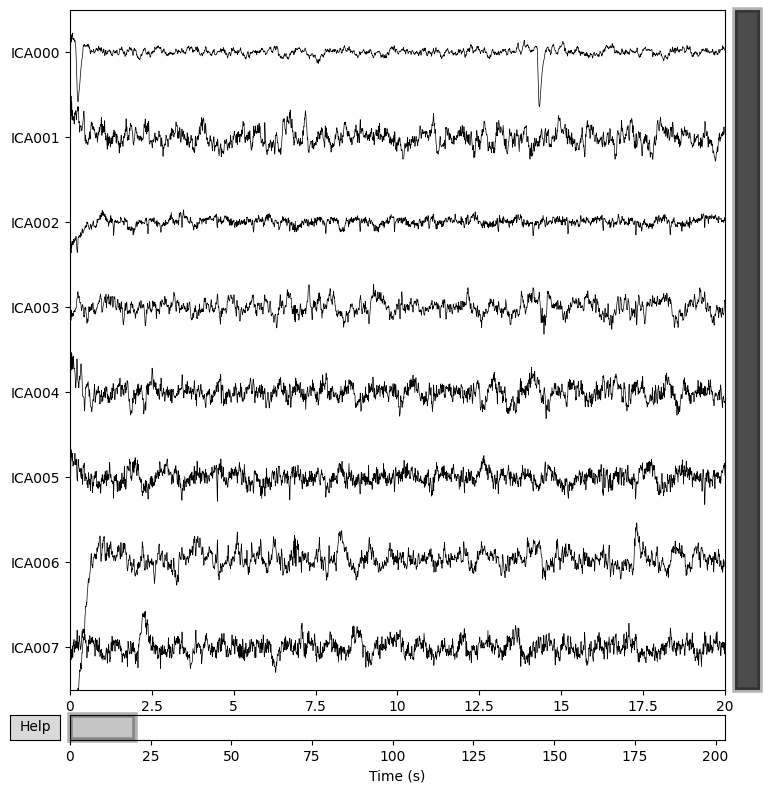

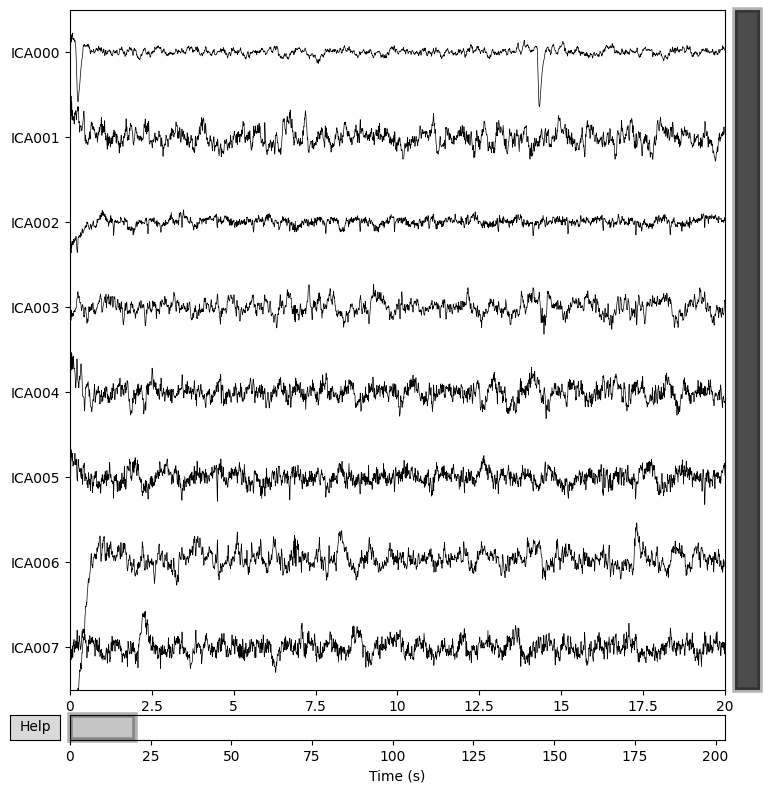

In [7]:
ica.plot_components()
ica.plot_sources(raw1)

In [8]:
# For example, remove components 0 and 1
ica.exclude = [0]

# Apply ICA to remove the marked components
ICA_filtered1 = ica.apply(raw1.copy())
ICA_filtered2 = ica.apply(raw2.copy())
ICA_filtered3 = ica.apply(raw3.copy())

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components


In [9]:
sfreq= 250
# event_index = np.array(event_data["time_series"]) #Get all event marker of experiment 
event_timestamp1 = (np.array(event_data1["time_stamps"]).T * sfreq) - (raw_stream1['time_stamps'][0] * sfreq) #Timestamp when event marked
event_timestamp2 = (np.array(event_data2["time_stamps"]).T * sfreq) - (raw_stream2['time_stamps'][0] * sfreq)
event_timestamp3 = (np.array(event_data3["time_stamps"]).T * sfreq) - (raw_stream3['time_stamps'][0] * sfreq)

In [10]:
event_index1 = []
event_index2 = []
event_index3 = []

for i in range (len(event_data1["time_series"])):
    # print(event_data["time_series"][i][0])
    event_index1.append(event_data1["time_series"][i][0])
    # np.append(event_index,event_data["time_series"][i][0])
for i in range (len(event_data2["time_series"])):
    # print(event_data["time_series"][i][0])
    event_index2.append(event_data2["time_series"][i][0])
    # np.append(event_index,event_data["time_series"][i][0])
for i in range (len(event_data3["time_series"])):
    # print(event_data["time_series"][i][0])
    event_index3.append(event_data3["time_series"][i][0])
    # np.append(event_index,event_data["time_series"][i][0])
np_event_index1 = np.array(event_index1)
np_event_index2 = np.array(event_index2)
np_event_index3 = np.array(event_index3)
print(np_event_index1,np_event_index2,np_event_index3)


['101' '101' '101' '201' '101' '201' '201' '101' '101' '101' '101' '101'
 '101' '101' '101' '101' '101' '101' '101' '101' '201' '101' '201' '101'
 '101' '201' '101' '101' '101' '101' '101' '101' '101' '101' '101' '201'
 '201' '101' '101' '101' '101' '101' '101' '201' '101' '101' '101' '201'
 '101' '101' ''] ['101' '101' '101' '101' '201' '101' '101' '101' '101' '101' '201' '101'
 '101' '201' '101' '101' '101' '101' '101' '101' '101' '201' '101' '101'
 '101' '101' '101' '101' '101' '101' '101' '101' '201' '101' '201' '101'
 '101' '201' '101' '101' '201' '101' '101' '101' '101' '101' '101' '201'
 '101' '201' ''] ['101' '101' '101' '201' '101' '101' '101' '101' '101' '101' '101' '201'
 '201' '101' '101' '101' '101' '101' '101' '201' '201' '201' '101' '201'
 '101' '101' '101' '101' '201' '101' '101' '101' '101' '101' '101' '101'
 '201' '101' '101' '101' '101' '101' '101' '101' '101' '101' '201' '101'
 '101' '101' '']


In [11]:
def check_Index(np_event_index,resp):
    real_event_index = []

    for i in range(len(np_event_index)):
        if np_event_index[i] == '101' and resp[i] != "space":
            real_event_index.append('101')
        elif  np_event_index[i] == '201' and resp[i] != "space":
            real_event_index.append('301')
        elif np_event_index[i] == '201' and resp[i] == "space" :
            real_event_index.append('201')
        else:
            real_event_index.append('')

    np_real_event_index  = np.array(real_event_index)
    print(np_real_event_index)
    return real_event_index,np_real_event_index

In [12]:
real_event_index1,_ = check_Index(np_event_index1,resp1)
real_event_index2,_ = check_Index(np_event_index2,resp2)
real_event_index3,_ = check_Index(np_event_index3,resp3)

['101' '101' '101' '201' '101' '201' '201' '101' '101' '101' '101' '101'
 '101' '101' '101' '101' '101' '101' '101' '101' '201' '101' '301' '101'
 '101' '201' '101' '101' '101' '101' '101' '101' '101' '101' '101' '201'
 '201' '101' '101' '101' '101' '101' '101' '201' '101' '101' '101' '201'
 '101' '101' '']
['101' '101' '101' '101' '201' '101' '101' '101' '101' '101' '201' '101'
 '101' '201' '101' '101' '101' '101' '101' '101' '101' '201' '101' '101'
 '101' '101' '101' '101' '101' '101' '101' '101' '201' '101' '201' '101'
 '101' '301' '101' '101' '201' '101' '101' '101' '101' '101' '101' '201'
 '101' '301' '']
['101' '101' '101' '301' '101' '101' '101' '101' '101' '101' '101' '301'
 '201' '101' '101' '101' '101' '101' '101' '201' '201' '201' '101' '301'
 '101' '101' '101' '101' '201' '101' '101' '101' '101' '101' '101' '101'
 '201' '101' '101' '101' '101' '101' '101' '101' '101' '101' '201' '101'
 '101' '101' '']


In [13]:
Ta = 0
Sta = 0
for i in real_event_index1:
    if i == '201':
        Ta += 1
    if i == '301':
        Sta +=1 
for i in real_event_index2:
    if i == '201':
        Ta += 1
    if i == '301':
        Sta +=1 
for i in real_event_index3:
    if i == '201':
        Ta += 1
    if i == '301':
        Sta +=1 
print(Ta,Sta)

24 6


In [14]:
events_id2 = {'101': 1,'201' : 2,'301' : 3,'': 5}

event_index1 = np.vectorize(events_id2.get)(real_event_index1)
event_index2 = np.vectorize(events_id2.get)(real_event_index2)
event_index3 = np.vectorize(events_id2.get)(real_event_index3)

In [15]:
events1 = np.column_stack((np.array(event_timestamp1, dtype = int),np.zeros(len(event_timestamp1), dtype = int),np.array(event_index1, dtype = int)))
events2 = np.column_stack((np.array(event_timestamp2, dtype = int),np.zeros(len(event_timestamp2), dtype = int),np.array(event_index2, dtype = int)))
events3 = np.column_stack((np.array(event_timestamp3, dtype = int),np.zeros(len(event_timestamp3), dtype = int),np.array(event_index3, dtype = int)))



In [25]:
OpenBCI_epochs1 = mne.Epochs(ICA_filtered1, events1, 
        tmin= -0.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 1.0,    # final timestamp (10 means set epoch duration 10 second)
        event_id =events_id2,
        preload = True,
        event_repeated='drop',
        baseline=(-0.5, 0)
    )
OpenBCI_epochs2 = mne.Epochs(ICA_filtered2, events2, 
        tmin= -0.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 1.0,    # final timestamp (10 means set epoch duration 10 second)
        event_id =events_id2,
        preload = True,
        event_repeated='drop',
        baseline=(-0.5, 0)
    )
OpenBCI_epochs3 = mne.Epochs(ICA_filtered3, events3, 
        tmin= -0.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 1.0,    # final timestamp (10 means set epoch duration 10 second)
        event_id =events_id2,
        preload = True,
        event_repeated='drop',
        baseline=(-0.5, 0)
    )

Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 51 events and 376 original time points ...
0 bad epochs dropped
Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 51 events and 376 original time points ...
0 bad epochs dropped
Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 51 events and 376 original time points ...
0 bad epochs dropped


In [26]:
# For 'Target' (event id: 201)
evoked_target_1 = OpenBCI_epochs1['201'].average()
evoked_target_2 = OpenBCI_epochs2['201'].average()
evoked_target_3 = OpenBCI_epochs3['201'].average()

# For 'SubTarget' (301)
evoked_subtarget_1 = OpenBCI_epochs1['301'].average()
evoked_subtarget_2 = OpenBCI_epochs2['301'].average()
evoked_subtarget_3 = OpenBCI_epochs3['301'].average()

# For 'NonTarget' (101)
evoked_nontarget_1 = OpenBCI_epochs1['101'].average()
evoked_nontarget_2 = OpenBCI_epochs2['101'].average()
evoked_nontarget_3 = OpenBCI_epochs3['101'].average()


In [27]:
from mne import combine_evoked

evoked_target = combine_evoked([evoked_target_1, evoked_target_2, evoked_target_3], weights='equal')
evoked_subtarget = combine_evoked([evoked_subtarget_1, evoked_subtarget_2, evoked_subtarget_3], weights='equal')
evoked_nontarget = combine_evoked([evoked_nontarget_1, evoked_nontarget_2, evoked_nontarget_3], weights='equal')


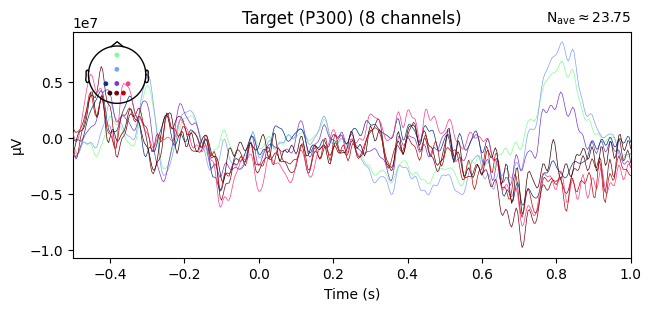

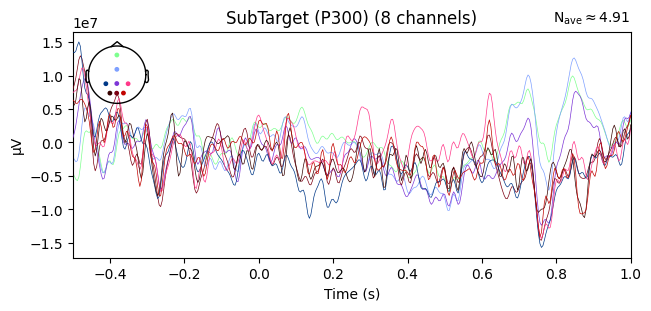

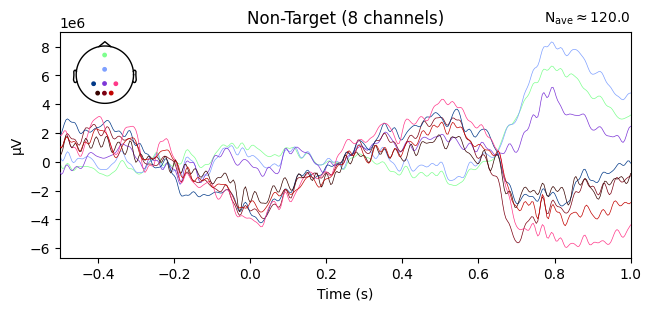

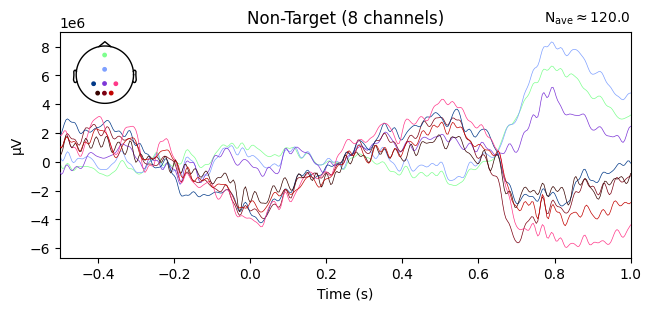

In [28]:
evoked_target.plot(spatial_colors=True, titles='Target (P300)')
evoked_subtarget.plot(spatial_colors=True, titles='SubTarget (P300)')
evoked_nontarget.plot(spatial_colors=True, titles='Non-Target')

In [29]:
evoked_target.times[-1]

np.float64(1.0)

combining channels using "mean"
combining channels using "mean"


C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_37628\3062382084.py:1: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(


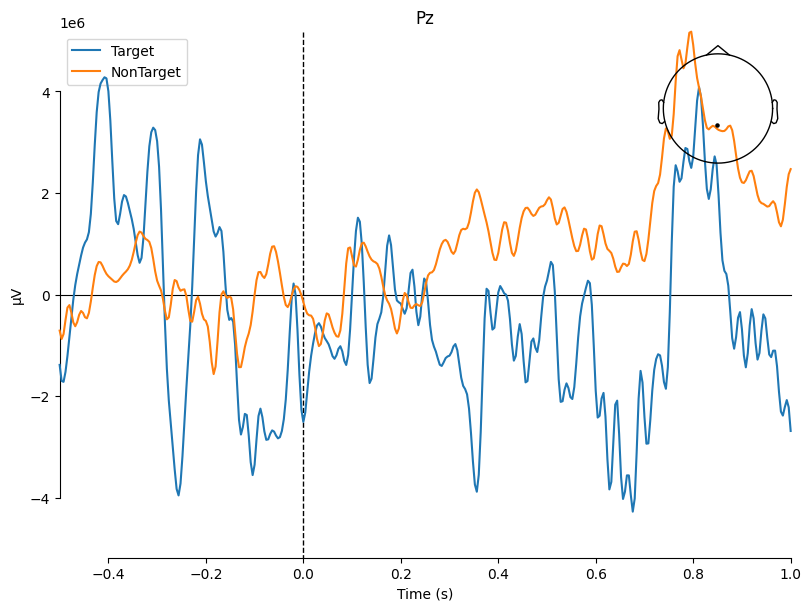

combining channels using "mean"
combining channels using "mean"


C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_37628\3062382084.py:10: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(


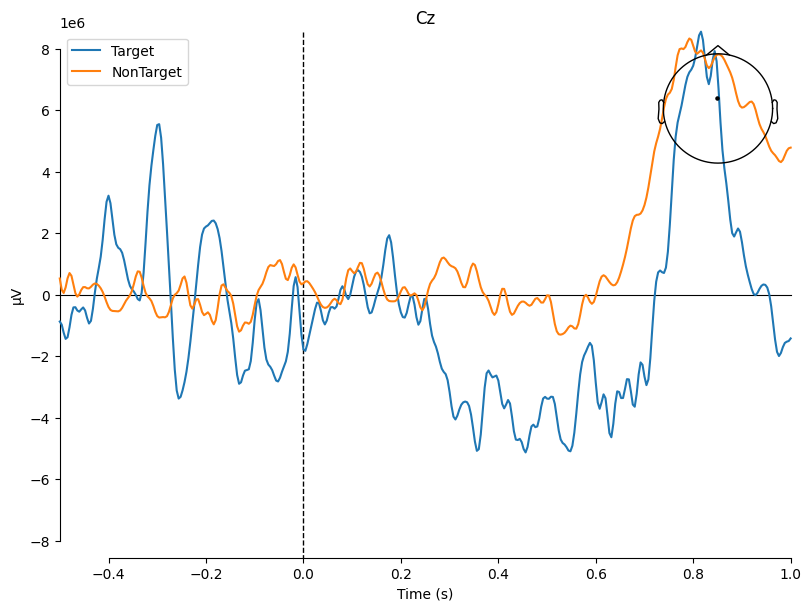

combining channels using "mean"
combining channels using "mean"


C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_37628\3062382084.py:19: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(


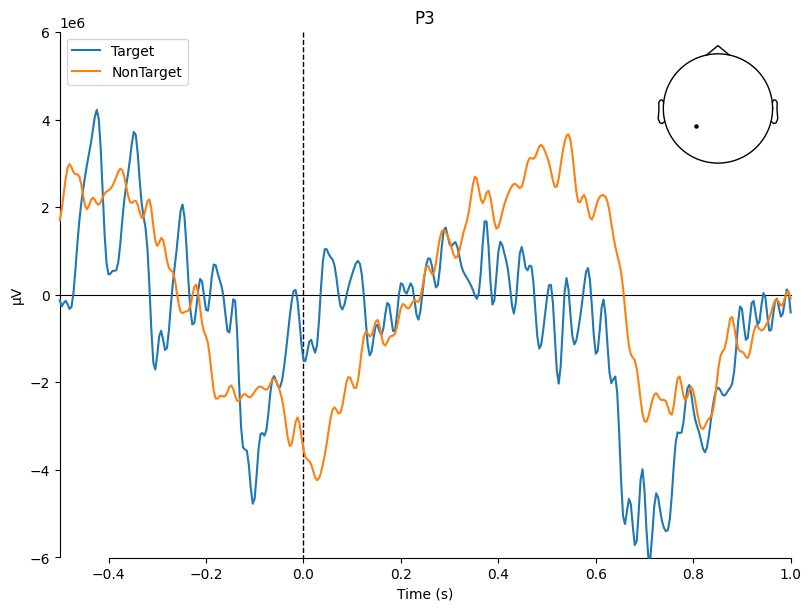

combining channels using "mean"
combining channels using "mean"


C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_37628\3062382084.py:29: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(


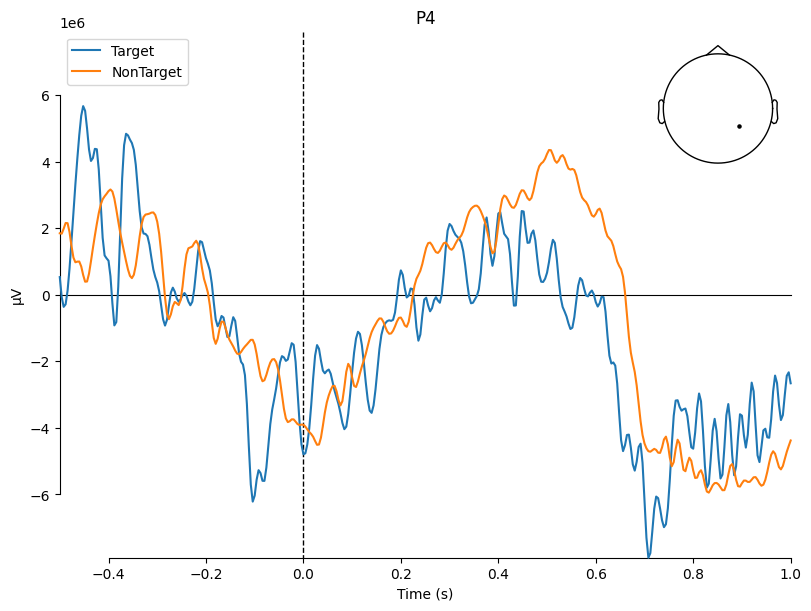

combining channels using "mean"
combining channels using "mean"


C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_37628\3062382084.py:40: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(


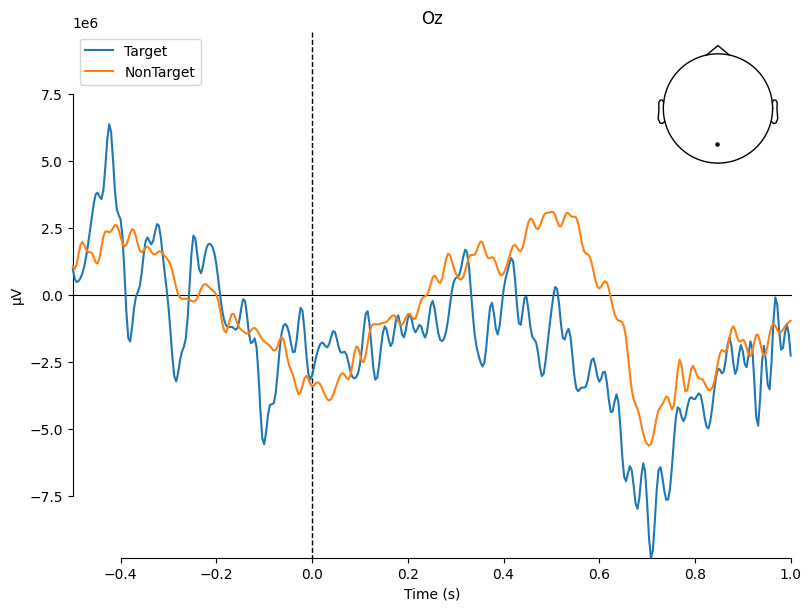

[<Figure size 800x600 with 2 Axes>]

In [34]:
mne.viz.plot_compare_evokeds(
    {
        'Target': evoked_target,
        # 'SubTarget': evoked_subtarget,
        'NonTarget': evoked_nontarget
    },
    picks='Pz',  # or your preferred channel
    combine='mean'
)
mne.viz.plot_compare_evokeds(
    {
        'Target': evoked_target,
        # 'SubTarget': evoked_subtarget,
        'NonTarget': evoked_nontarget
    },
    picks='Cz',  # or your preferred channel
    combine='mean'
)
mne.viz.plot_compare_evokeds(
    {
        'Target': evoked_target,
        # 'SubTarget': evoked_subtarget,
        'NonTarget': evoked_nontarget
    },
    picks='P3',  # or your preferred channel
    combine='mean'
)

mne.viz.plot_compare_evokeds(
    {
        'Target': evoked_target,
        # 'SubTarget': evoked_subtarget,
        'NonTarget': evoked_nontarget
    },
    picks='P4',  # or your preferred channel
    combine='mean'
)


mne.viz.plot_compare_evokeds(
    {
        'Target': evoked_target,
        # 'SubTarget': evoked_subtarget,
        'NonTarget': evoked_nontarget
    },
    picks='Oz',  # or your preferred channel
    combine='mean'
)


Need more than one channel to make topography for eeg. Disabling interactivity.


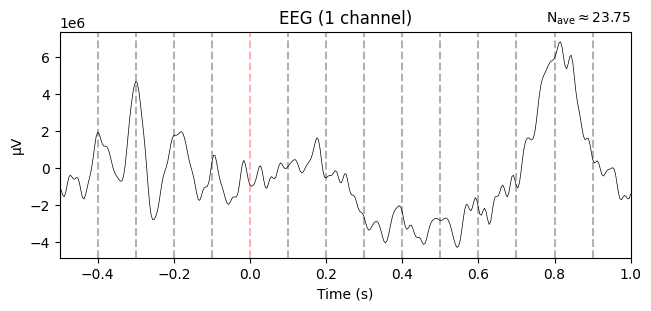

In [31]:
evoked = evoked_target
fig1 = evoked.plot(picks='Fz', show=False)
ax = fig1.axes[0]

# Add vertical lines every 100ms
for t in np.arange(evoked.times[0], evoked.times[-1], 0.1):
    if t > -0.05 and t < 0.05:
        ax.axvline(t, linestyle='--', color='red', alpha=0.3)
    else:
        ax.axvline(t, linestyle='--', color='black', alpha=0.3)

plt.show()

Need more than one channel to make topography for eeg. Disabling interactivity.


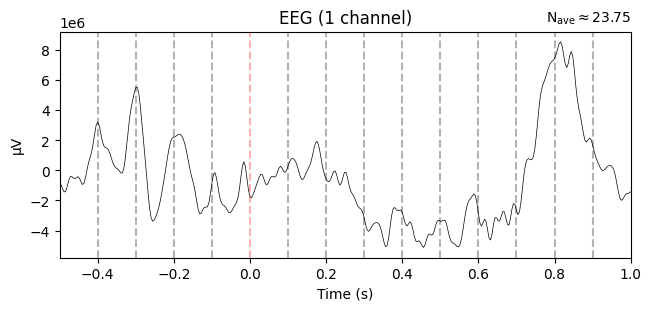

In [32]:
fig2 = evoked.plot(picks='Cz', show=False)
ax = fig2.axes[0]

# Add vertical lines every 100ms
for t in np.arange(evoked.times[0], evoked.times[-1], 0.1):
    if t > -0.05 and t < 0.05:
        ax.axvline(t, linestyle='--', color='red', alpha=0.3)
    else:
        ax.axvline(t, linestyle='--', color='black', alpha=0.3)

plt.show()

Need more than one channel to make topography for eeg. Disabling interactivity.


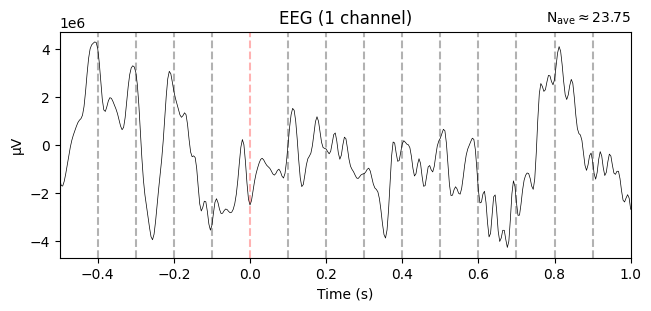

In [33]:
fig3 = evoked.plot(picks='Pz', show=False)
ax = fig3.axes[0]

# Add vertical lines every 100ms
for t in np.arange(evoked.times[0], evoked.times[-1], 0.1):
    if t > -0.05 and t < 0.05:
        ax.axvline(t, linestyle='--', color='red', alpha=0.3)
    else:
        ax.axvline(t, linestyle='--', color='black', alpha=0.3)

plt.show()